In [1]:
#Misc
import signal
import sys
sys.path.append("../../../")
sys.path.append("../")
from loss_functions_lib import *
from utils import build_sequential_data, data, targets
from NN import MNIST_feature_map
#Torch
import torch
from torch.utils.data import DataLoader, TensorDataset

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

#Numpy-Matplotlib-tqdm-sklearn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
#DynamicalSystems
from kooplearn.kernels import Linear, RBF, TorchScalarProduct
from kooplearn.estimators import KernelRidge, ReducedRank

In [2]:
d = 28 #Image Size in px
#Hyperparameter initialization
tikhonov_reg_linear = 48.3293 #CV
gamma_linear = d**-2 #CV
tikhonov_reg_RBF = 0.00785 #CV
RBF_length_scale = 28*28

In [51]:
#Datasets initialization
num_classes = 3
num_train_samples = 1000
num_val_samples = 1000
batch_size = 100

sorting_permutation = build_sequential_data(num_classes=num_classes)

dataset = data[sorting_permutation].reshape(-1,d**2)/256 - 0.5 #Standardizing dataset
torch_dataset = torch.from_numpy(dataset)

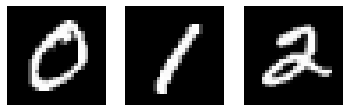

In [52]:
n_examples = num_classes
fig, axes = plt.subplots(1, ncols=n_examples)
for idx in range(n_examples):
    axes[idx].imshow(dataset[idx].reshape(d,d), cmap='gray') 
    axes[idx].axis('off')

In [53]:
#Training init
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_torch = torch_dataset[:-1].reshape((-1,1, d, d)) #Reshaping for conv2d
Y_torch = torch_dataset[1:]

tensor_dataset = TensorDataset(X_torch[:num_train_samples], Y_torch[:num_train_samples])
val_dataset = (X_torch[num_train_samples:(num_train_samples + num_val_samples)].to(device), Y_torch[num_train_samples:(num_train_samples + num_val_samples)].to(device))
loader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

#### Train CNN-Kernel

In [54]:
def classifier_train(num_epochs, cnn, loss_fn, loader, lr = 1e-3):
    optimizer = torch.optim.Adam(cnn.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)  
    cnn.train()
    X_val, Y_val = val_dataset
    # Train the model
    for epoch in range(num_epochs):
        for i, (X, Y) in enumerate(loader):   
            #loss = kernel_target_alignment(cnn, X.to(device), Y.to(device))
            loss = loss_fn(cnn, X.to(device), Y.to(device))
            # clear gradients for this training step   
            optimizer.zero_grad()             
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()

        with torch.no_grad():
            val_loss = loss_fn(cnn, X_val, Y_val)
            writer.add_scalars("Loss", {
                'Training': loss,
                'Validation': val_loss
                }, epoch)
        #print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs,loss.item()))
    writer.flush()

In [55]:
loss_fn = VAMP
net = MNIST_feature_map(out_features=num_classes + 1).to(device)
classifier_train(20, net,loss_fn, loader, lr=1e-1)
net.eval()

MNIST_feature_map(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin): Sequential(
    (0): Linear(in_features=1568, out_features=4, bias=True)
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
)

### Learning with Linear, RBF and DeepKernel

In [56]:
def feature_map(x):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x).to(torch.float)
    if not x.device == device:
        x = x.to(device)
    return net(x)

cnn_kernel = TorchScalarProduct(feature_map)
kernels = [Linear(gamma=gamma_linear), RBF(length_scale = 28*28), cnn_kernel]
tikhonov_regs = [tikhonov_reg_linear, tikhonov_reg_RBF, 1e-6]
trained_estimators = []
X = dataset[:-1]
Y = dataset[1:]

X_train = X[:num_train_samples]
Y_train = Y[:num_train_samples] 

for k_idx, kernel in enumerate(kernels):
    K = KernelRidge(kernel=kernel, tikhonov_reg=tikhonov_regs[k_idx])
    K.fit(X_train, Y_train)
    trained_estimators.append(K)

[ 0.30215102 -0.25290012  0.2917842  -0.30381364]


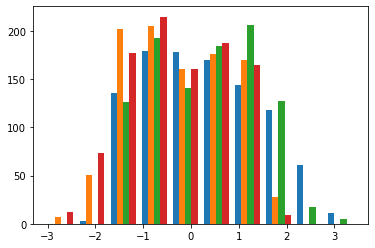

In [57]:
with torch.no_grad():
    phi = feature_map(Y_train).cpu().numpy()
    plt.hist(phi)
    print(phi.mean(axis=0))

### Debugging

In [58]:
with torch.no_grad():
    C_X = covariance_matrix(net, X_torch[:num_train_samples].to(device), X_torch[:num_train_samples].to(device)).cpu().numpy()
    C_Y = covariance_matrix(net, Y_torch[:num_train_samples].to(device), Y_torch[:num_train_samples].to(device)).cpu().numpy()
    T = covariance_matrix(net, X_torch[:num_train_samples].to(device), Y_torch[:num_train_samples].to(device)).cpu().numpy()

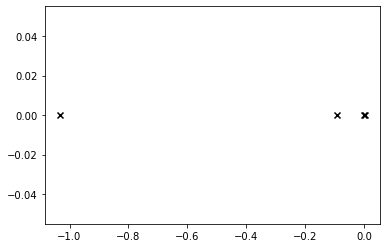

In [59]:
w_T = np.linalg.eigvals(T)
plt.scatter(w_T.real, w_T.imag, color='k', marker = 'x')

In [60]:
w_T

array([-1.0316949e+00, -9.2411563e-02,  8.7481615e-04,  3.9616501e-05],
      dtype=float32)

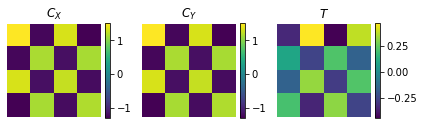

In [61]:
fig, axes = plt.subplots(1, 3)
plot_data = zip([C_X, C_Y, T], ["$C_{X}$", "$C_{Y}$", "$T$"])
for idx, (M, title) in enumerate(plot_data):
    pcm = axes[idx].imshow(M) 
    axes[idx].axis('off')
    axes[idx].set_title(title)
    fig.colorbar(pcm, ax=axes[idx], fraction=0.046, pad=0.04)
plt.tight_layout()

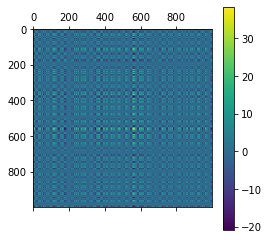

In [62]:
plt.matshow(trained_estimators[-1].K_X_)
plt.colorbar()

### Testing: one-step-ahead prediction

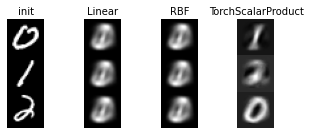

In [82]:
seed = 3 # int parameter
idx_0 = num_train_samples + num_classes -  num_train_samples%num_classes + seed

data_storage = [X[idx_0:idx_0 + num_classes].reshape(num_classes, d, d)]
labels = ['init']


#Data Generation
for estimator in trained_estimators:
    kernel_name = estimator.kernel.__class__.__name__
    predictions = estimator.predict(data_storage[0].reshape(num_classes, d**2))
    data_storage.append(predictions.reshape(num_classes, d, d))
    labels.append(kernel_name)

#Data plotting
fig_width = 5.5 #Inches
fig_height = 2 #Inches
nrows = num_classes
ncols = len(data_storage)
fig, axes = plt.subplots(nrows = nrows, ncols=ncols, figsize=(fig_width, fig_height))
plt.subplots_adjust(wspace=0, hspace=0)
for row in range(nrows):
    for col in range(ncols):
        ax = axes[row, col]
        ax.axis('off')
        Y_val = data_storage[col][row]
        ax.imshow(Y_val, cmap="gray")
        if row == 0:
            ax.text(14, -4, labels[col], ha='center')